# sampling out 되는 데이터들이 어떤 데이터인지 3d 시각화

- 작은 AE 모델 구현
- 훈련
  - sampling out 저장
- 시각화

In [92]:
from sklearn.datasets import make_classification
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle
import winsound

- 다양한 형태의 데이터를 사용하자!

Text(0, 0.5, 'x1')

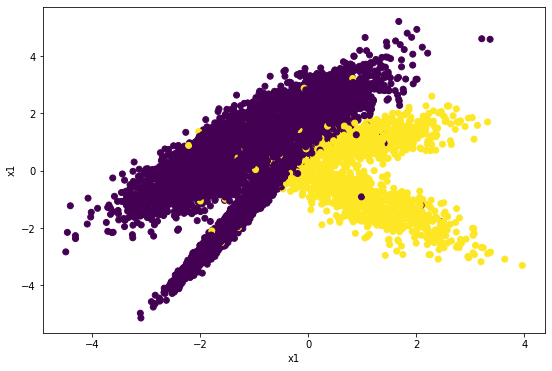

In [93]:
X1, y1 = make_classification(n_samples=int(10000/ 0.7 / 0.9), n_features=2, n_informative=2, n_redundant=0,  n_classes=2, weights=[0.9,0.1], random_state=0)
fig = plt.figure(figsize=(9, 6))
# Create 3D container
ax = plt.axes()
# Visualize 3D scatter plot
ax.scatter(X1[: ,0], X1[: ,1], c=y1)
# Give labels
ax.set_xlabel('x1')
ax.set_ylabel('x1')

Text(0, 0.5, 'x1')

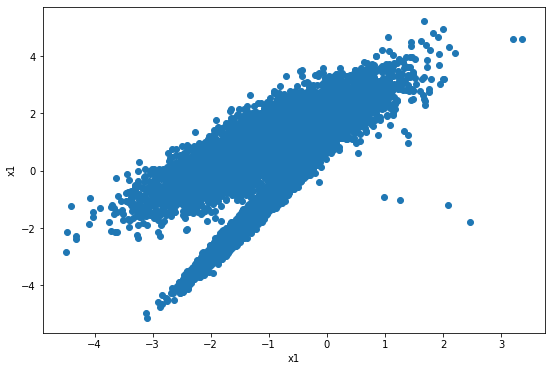

In [94]:
X1_normal = X1[y1 == 0]

fig = plt.figure(figsize=(9, 6))
# Create 3D container
ax = plt.axes()
# Visualize 3D scatter plot
ax.scatter(X1_normal[: ,0], X1_normal[: ,1])
# Give labels
ax.set_xlabel('x1')
ax.set_ylabel('x1')

In [95]:
df = pd.DataFrame(X1)
df['label'] = y1

In [96]:
from src.models.AutoEncoderForViz import VizAE
from src.dataload.tabular import tabularDataset
from src.utils import ensemble_inference, inference
from src.simulation_trainer import BaseTrainer, NewTrainer

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def _normalize_tabular(df: pd.DataFrame, label_name: str = "label"):
    scaler = StandardScaler()
    X = scaler.fit_transform(df.drop(label_name, axis=1))
    y = df[label_name]
    return X, y

def simul_split_train_valid_test(df: pd.DataFrame, train_ratio: float = 0.7):
    X, y = _normalize_tabular(df)
    tmp = pd.DataFrame(X)
    tmp["label"] = y
    normal = tmp.loc[tmp["label"] == 0, :].reset_index(drop=True)
    abnormal = tmp.loc[tmp["label"] == 1, :].reset_index(drop=True)
    X_train, X_val_test, y_train, y_val_test = train_test_split(
        normal.drop("label", axis=1),
        normal["label"],
        train_size=train_ratio,
        random_state=42,
        shuffle=False,
    )
    
    X_val, X_test, y_val, y_test = train_test_split(
        X_val_test, y_val_test, train_size=0.5, random_state=42, shuffle=False
    )
    X_test["label"] = y_test
    X_test = pd.concat([X_test, abnormal]).reset_index(drop=True)
    return (
        X_train.values,
        X_val.values,
        X_test.drop("label", axis=1).values,
        y_train.values,
        y_val.values,
        X_test["label"].values,
    )

In [97]:
from argparse import Namespace

config = {
    'trainer_name' : 'BaseTrainer',
    'project' : 'my_paper',
    'train_ratio': .7,
    'batch_size': 512,
    'n_epochs': 300,
    'early_stop_round': 1000,
    'hidden_size': [2],
    'window_size': 60,
    'data': 'tabular',
    # 'sampling_term': [1, 5],
    'sampling_term': [1, 5],
    # 'initial_epochs': [10],
    'initial_epochs': [5, 20],
    'sampling_ratio': [0.01, 0.1]
}

# gpu
gpu_id = 0 if torch.cuda.is_available() else -1

if gpu_id == 0:
    config['device'] = 'cuda:0'
else:
    config['device'] = 'cpu'

config = Namespace(**config)

print(config)

Namespace(batch_size=512, data='tabular', device='cuda:0', early_stop_round=1000, hidden_size=[2], initial_epochs=[5, 20], n_epochs=300, project='my_paper', sampling_ratio=[0.01, 0.1], sampling_term=[1, 5], train_ratio=0.7, trainer_name='BaseTrainer', window_size=60)


In [98]:
n_time = 1
save_idx = '_0'
config.data_name = 'viz2D'
is_debug = True

for i in range(n_time):
    print(f'<< {i+1}번재 시작 >>')
    (
        train_x,
        valid_x,
        test_x,
        train_y,
        valid_y,
        test_y,
    ) = simul_split_train_valid_test(df, config.train_ratio)
    
    # resize 'window_size' = 'col_len'
    config.window_size = train_x.shape[1]

    train_dataset = tabularDataset(train_x, train_y)
    valid_dataset = tabularDataset(valid_x, valid_y)
    test_dataset = tabularDataset(test_x, test_y)

    train_dataloader = DataLoader(
        train_dataset, shuffle=False, batch_size=config.batch_size
    )
    valid_dataloader = DataLoader(
        valid_dataset, shuffle=False, batch_size=config.batch_size
    )
    test_dataloader = DataLoader(
        test_dataset, shuffle=False, batch_size=config.batch_size
    )

    total_x = np.concatenate([train_x, valid_x, test_x])
    total_y = np.concatenate([train_y, valid_y, test_y])
    IR = round((len(total_y) - np.sum(total_y)) / np.sum(total_y), 4)
    
    # for inference
    total_dataset = tabularDataset(total_x, total_y)
    total_dataloader = DataLoader(
        total_dataset, shuffle=False, batch_size=config.batch_size
    )   
    for hidden_size in config.hidden_size:
        for sampling_ratio in config.sampling_ratio:
            for initial_epoch in config.initial_epochs: 
                for sampling_term in config.sampling_term:
                    print(
                        f"-----NewTrainer starts-----"
                    )
                    config.trainer_name = "NewTrainer"

                    model = VizAE(
                        input_size=config.window_size,
                        hidden_size=1,
                        output_size=config.window_size,
                        dropout_p=0.2,
                    ).to(config.device)

                    optimizer = optim.Adam(model.parameters())
                    criterion = nn.MSELoss()

                    # train
                    trainer = NewTrainer(model=model, optimizer=optimizer, crit=criterion)
                    
                    train_loss, val_loss, return_epoch, best_model, errors, tops, downs = trainer.train(
                        train_x=train_x,
                        train_y=train_y,
                        train_loader=train_dataloader,
                        val_loader=valid_dataloader,
                        sampling_term=sampling_term,
                        initial_epoch=initial_epoch,
                        sampling_ratio=sampling_ratio,
                        config=config,
                        use_wandb=False,
                        is_debug=is_debug
                    )
                    if is_debug:
                        hp = '_h' + str(hidden_size) + '_st' + str(sampling_term) + '_sr' + str(sampling_ratio) + '_ie' + str(initial_epoch)
                        with open('./run_result_sim_error/newError_'+ config.data_name + hp + save_idx + '.pickle', 'wb') as f:
                            pickle.dump(errors, f, pickle.HIGHEST_PROTOCOL)
                        with open('./run_result_sim_top/newTop_'+ config.data_name + hp + save_idx + '.pickle', 'wb') as f:
                            pickle.dump(tops, f, pickle.HIGHEST_PROTOCOL)
                        with open('./run_result_sim_down/newDown_'+ config.data_name + hp + save_idx + '.pickle', 'wb') as f:
                            pickle.dump(downs, f, pickle.HIGHEST_PROTOCOL)
                    
                    # best_model.to("cpu")                                

                    # df, tst_ano_score = ensemble_inference(
                    #     config,
                    #     total_dataloader,
                    #     best_model,
                    #     train_x,
                    #     valid_x,
                    #     total_x,
                    #     total_y,
                    #     return_epoch,
                    #     hidden_size,
                    #     train_loss,
                    #     val_loss,
                    #     IR,
                    #     sampling_term,
                    #     sampling_ratio,
                    #     initial_epoch,
                    #     PATH
                    # )
                    # df.to_csv(PATH + "result_" + config.data_name + ".csv", index=False)
                    
                    # hp = '_hs' + str(hidden_size) + '_st' + str(sampling_term) + '_sr' + str(sampling_ratio) + '_ie' + str(initial_epoch)
                    # with open('./ensemble_sim_3/' + config.data_name + hp + '.pickle', 'wb') as f:
                    #     pickle.dump(tst_ano_score, f, pickle.HIGHEST_PROTOCOL)
                    
                    torch.cuda.empty_cache()
                                            
frequency = 800
duration = 2000
winsound.Beep(frequency, duration)

<< 1번재 시작 >>
-----NewTrainer starts-----


<ipython-input-96-88c5f7c2a1c6>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["label"] = y_test


train_loss=0.471, valid_loss=0.373
-----NewTrainer starts-----
train_loss=0.355, valid_loss=0.229
-----NewTrainer starts-----
train_loss=0.343, valid_loss=0.206
-----NewTrainer starts-----
train_loss=0.337, valid_loss=0.200
-----NewTrainer starts-----
train_loss=0.433, valid_loss=0.379
-----NewTrainer starts-----
train_loss=0.322, valid_loss=0.230
-----NewTrainer starts-----
train_loss=0.417, valid_loss=0.371
-----NewTrainer starts-----
train_loss=0.698, valid_loss=0.848


In [234]:
import os

data_list = [data for data in os.listdir('./run_result_sim_down') if 'viz2D' in data]

In [235]:
import pickle

with open('./run_result_sim_down/' + data_list[2], 'rb') as f:
    tmp = pickle.load(f)

In [236]:
def color(epoch):
    c = np.zeros(train_x.shape[0])
    for i in tmp[:, epoch]:
        c[int(i)] = 1
    return c

c = color(50)

Text(0.5, 1.0, 'sampled-out instances (yellow)')

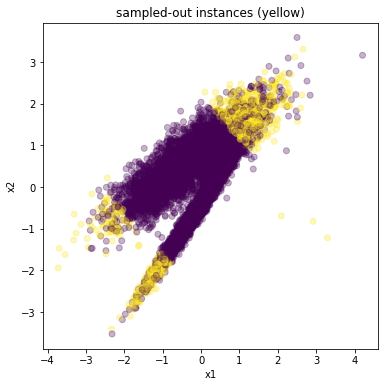

In [237]:
fig = plt.figure(figsize=(6, 6))
# Create 3D container
ax = plt.axes()
# Visualize 3D scatter plot
ax.scatter(train_x[: ,0], train_x[: ,1], c=c, alpha=0.3)
# Give labels
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('sampled-out instances (yellow)')

In [238]:
import os

data_list = [data for data in os.listdir('./run_result_sim_top') if 'viz2D' in data]
data_list

['newTop_viz2D_h2_st1_sr0.01_ie20_0.pickle',
 'newTop_viz2D_h2_st1_sr0.01_ie5_0.pickle',
 'newTop_viz2D_h2_st1_sr0.1_ie20_0.pickle',
 'newTop_viz2D_h2_st1_sr0.1_ie5_0.pickle',
 'newTop_viz2D_h2_st5_sr0.01_ie20_0.pickle',
 'newTop_viz2D_h2_st5_sr0.01_ie5_0.pickle',
 'newTop_viz2D_h2_st5_sr0.1_ie20_0.pickle',
 'newTop_viz2D_h2_st5_sr0.1_ie5_0.pickle']

In [239]:
import pickle

with open('./run_result_sim_top/' + data_list[2], 'rb') as f:
    tmp = pickle.load(f)

In [240]:
def color(epoch):
    c = np.zeros(train_x.shape[0])
    for i in tmp[:, epoch]:
        c[int(i)] = 1
    return c

c = color(50)

Text(0.5, 1.0, 'sampled-in instances (yellow)')

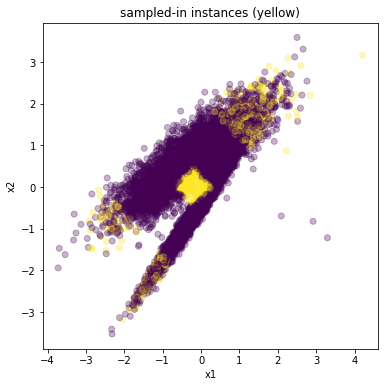

In [241]:
fig = plt.figure(figsize=(6, 6))
# Create 3D container
ax = plt.axes()
# Visualize 3D scatter plot
ax.scatter(train_x[: ,0], train_x[: ,1], c=c, alpha=0.3)
# Give labels
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('sampled-in instances (yellow)')